In [1]:
# pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.utils import resample
warnings.filterwarnings('ignore')


In [3]:
# Load data
data = pd.read_csv('augmented_file_50x.csv')

In [4]:
data['label'].value_counts()

label
rice           5000
maize          5000
jute           5000
cotton         5000
coconut        5000
papaya         5000
orange         5000
apple          5000
muskmelon      5000
watermelon     5000
grapes         5000
mango          5000
banana         5000
pomegranate    5000
lentil         5000
blackgram      5000
mungbean       5000
mothbeans      5000
pigeonpeas     5000
kidneybeans    5000
chickpea       5000
coffee         5000
Name: count, dtype: int64

In [5]:
data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,50.551818,53.362727,48.149091,25.616123,71.481866,6.469327,103.463667
std,36.909110,32.978535,50.636649,5.062866,22.258952,0.775523,54.946209
min,-0.000000,5.000000,5.000000,8.693522,14.132941,3.382286,20.100759
25%,21.000000,28.000000,20.000000,22.761534,60.252213,5.970163,64.530224
50%,37.000000,51.000000,32.000000,25.595386,80.475355,6.424988,94.870159
75%,84.250000,68.000000,49.000000,28.558985,89.956770,6.920756,124.296449
max,140.000000,145.000000,205.000000,43.800557,100.124082,10.040529,298.696561


<Axes: xlabel='rainfall', ylabel='Density'>

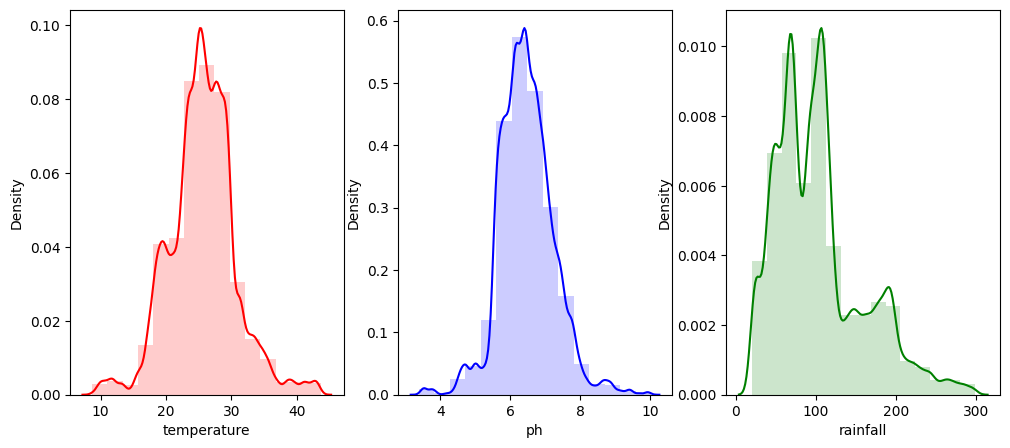

In [6]:
# Visualizing the data distribution between temperature, ph and rainfall

plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.distplot(data['temperature'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['ph'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['rainfall'],color="green",bins=15,hist_kws={'alpha':0.2})


<Axes: xlabel='K', ylabel='Density'>

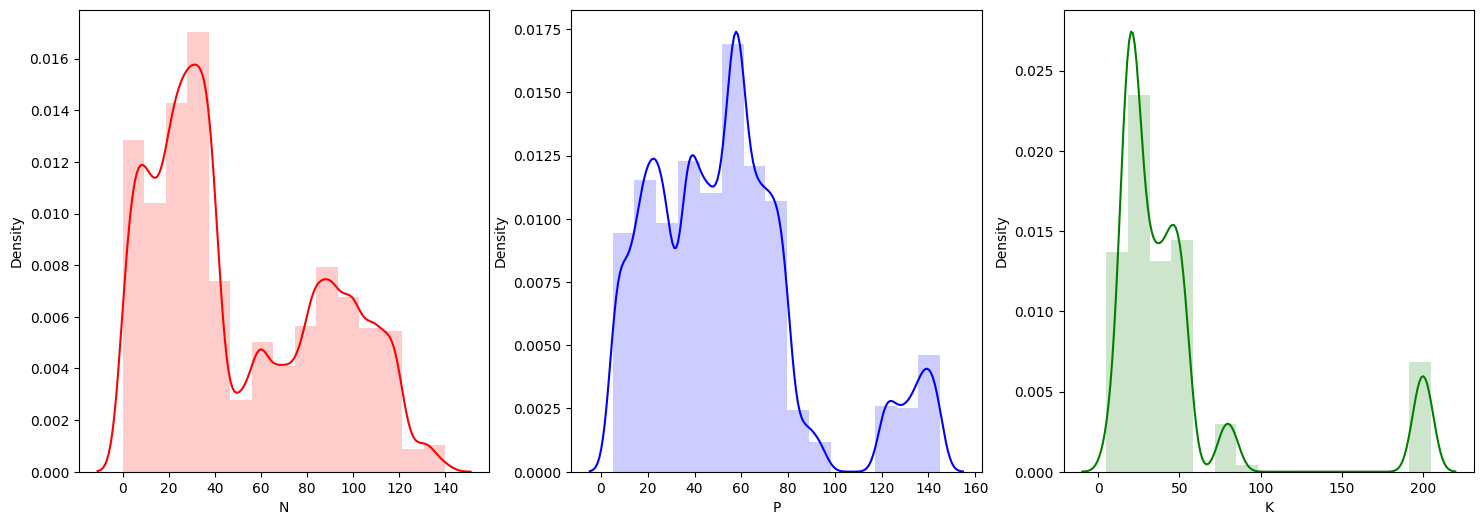

In [7]:
# Visualizing the data distribution between N, P, and K

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
sns.distplot(data['N'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['P'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['K'],color="green",bins=15,hist_kws={'alpha':0.2})

In [8]:

# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Lists to collect split data
X_train_list = []
X_val_list = []
X_test_list = []
y_train_list = []
y_val_list = []
y_test_list = []

# Split each label's data separately
labels = y.unique()
for label in labels:
    X_label = X[y == label]
    y_label = y[y == label]
    
    # First, separate out the training data (70%)
    X_train_label, X_temp_label, y_train_label, y_temp_label = train_test_split(
        X_label, y_label, test_size=0.30, random_state=0)
    
    # Now, split the remaining data into validation and test sets (20% test, 10% validation)
    X_test_label, X_val_label, y_test_label, y_val_label = train_test_split(
        X_temp_label, y_temp_label, test_size=0.3333, random_state=0)
    
    X_train_list.append(X_train_label)
    X_val_list.append(X_val_label)
    X_test_list.append(X_test_label)
    y_train_list.append(y_train_label)
    y_val_list.append(y_val_label)
    y_test_list.append(y_test_label)

# Concatenate splits
X_train = pd.concat(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
X_val = pd.concat(X_val_list, axis=0)
y_val = pd.concat(y_val_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))


Training set size: 77000
Validation set size: 11000
Testing set size: 22000


Cross-validated accuracy scores for each fold: [0.9512987  0.95948052 0.94779221 0.94792208 0.94909091 0.95038961
 0.94636364 0.95       0.94831169 0.94779221]
Mean CV Accuracy: 0.9498441558441559
Standard Deviation of CV Accuracy: 0.0034991746611391645
Calibrated Random Forest Validation accuracy: 0.9672727272727273
Calibrated Random Forest Test accuracy: 0.9683181818181819
Calibrated Random Forest Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.99      0.99      0.99      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      0.96      0.98      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.89      0.42      0.58      1000
 kidneybeans       1.00     

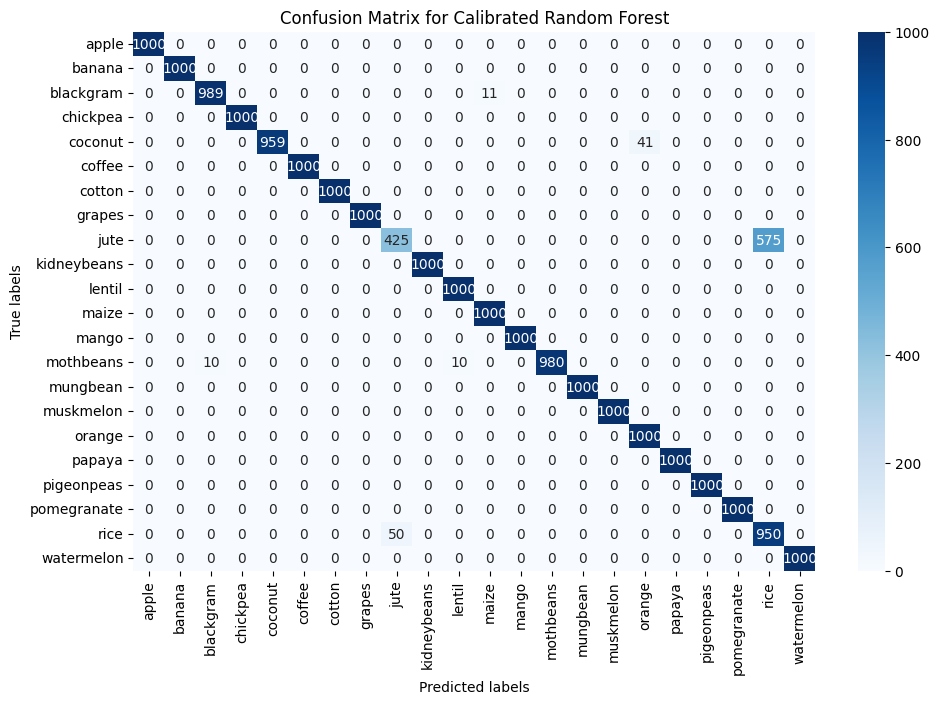

In [17]:
# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_resampled, y_resampled = under.fit_resample(X_train, y_train)

# Train the Random Forest on the resampled data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=4, random_state=0)
clf_rf.fit(X_resampled, y_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores = cross_val_score(clf_rf, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Calibrate the classifier on the validation set
calibrated_rf = CalibratedClassifierCV(clf_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_val, y_val)

# Predict on the validation set using the calibrated RF
y_pred_val = calibrated_rf.predict(X_val)
accuracy_score_val = accuracy_score(y_val, y_pred_val)
print("Calibrated Random Forest Validation accuracy:", accuracy_score_val)

# Predict on the test set using the calibrated RF
y_pred_calibrated = calibrated_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_calibrated)
print("Calibrated Random Forest Test accuracy:", accuracy_rf)
print("Calibrated Random Forest Test Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Compute metrics for model_metrics dictionary
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_calibrated, average='weighted')
model_metrics_rf= {
    "Random Forest": {
        "Accuracy": f"{accuracy_rf * 100:.2f}%",
        "Precision": f"{precision_rf * 100:.2f}%",
        "Recall": f"{recall_rf * 100:.2f}%",
        "F1 Score": f"{f1_rf * 100:.2f}%"
    }
}
print("Model Metrics for Random Forest", model_metrics_rf)

# Compute the confusion matrix for calibrated RF
conf_mat_calibrated = confusion_matrix(y_test, y_pred_calibrated)
class_labels = np.unique(y_test)

# Plot using Seaborn for calibrated RF
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_calibrated, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Calibrated Random Forest')
plt.show()


Cross-validated accuracy scores for each fold (KNN): [0.95883117 0.95805195 0.95519481 0.95857143 0.95480519 0.95714286
 0.95649351 0.95363636 0.95597403 0.95311688]
Mean CV Accuracy (KNN): 0.956181818181818
Standard Deviation of CV Accuracy (KNN): 0.0018982375470746422
K-nearest Neighbors Validation accuracy: 0.9567272727272728
K-nearest Neighbors Test accuracy: 0.9570454545454545
K-nearest Neighbors Test Classification Report:
              precision    recall  f1-score   support

       apple       0.88      1.00      0.94      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.89      0.99      0.94      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.98      1.00      0.99      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      0.87      0.93      1000
        jute       0.79      1.00      0.88      1000
 kidneybeans       0.92   

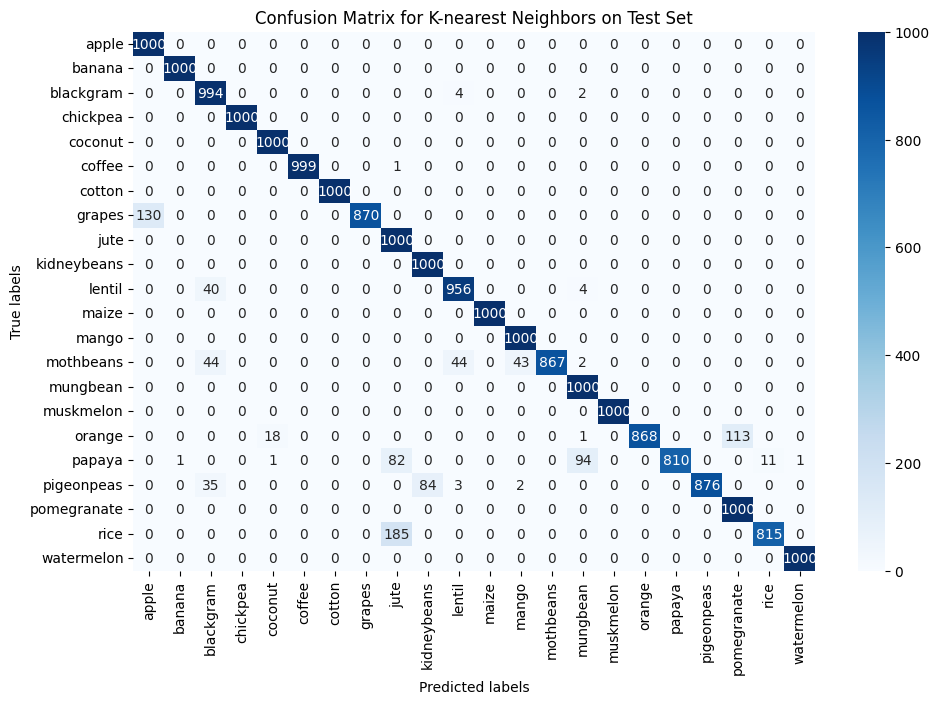

In [10]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) # scale the validation set
X_test_scaled = scaler.transform(X_test)

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')

# Apply the undersampling strategy
X_train_resampled, y_train_resampled = under.fit_resample(X_train_scaled, y_train)

# Define the K-nearest neighbors (KNN) classifier with adjusted parameters
clf_knn = KNeighborsClassifier(n_neighbors=5001, weights='distance', algorithm='auto', p=2)

# Fit the KNN model with resampled training data
clf_knn.fit(X_train_resampled, y_train_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores_knn = cross_val_score(clf_knn, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold (KNN):", cv_scores_knn)
print("Mean CV Accuracy (KNN):", cv_scores_knn.mean())
print("Standard Deviation of CV Accuracy (KNN):", cv_scores_knn.std())

# Predict using the KNN model on the scaled validation set
y_pred_knn_val = clf_knn.predict(X_val_scaled)
accuracy_score_knn_val = accuracy_score(y_val, y_pred_knn_val)
print("K-nearest Neighbors Validation accuracy:", accuracy_score_knn_val)

# Predict using the KNN model on the scaled test set
y_pred_knn = clf_knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("K-nearest Neighbors Test accuracy:", accuracy_knn)
print("K-nearest Neighbors Test Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Compute metrics for model_metrics dictionary
precision_knn, recall_knn, f1_knn, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='weighted')
model_metrics_knn = {
    "Accuracy": f"{accuracy_knn * 100:.2f}%",
    "Precision": f"{precision_knn * 100:.2f}%",
    "Recall": f"{recall_knn * 100:.2f}%",
    "F1 Score": f"{f1_knn * 100:.2f}%"
}

# Compute the confusion matrix for test set
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Use the previously established method to extract unique class labels
class_labels = np.unique(y_test)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_knn, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-nearest Neighbors on Test Set')
plt.show()


Cross-validated accuracy scores for each fold: [0.96116883 0.95688312 0.95805195 0.95402597 0.95753247 0.96064935
 0.95896104 0.9587013  0.96324675 0.95558442]
Mean CV Accuracy: 0.9584805194805194
Standard Deviation of CV Accuracy: 0.0025844155844155867
Naive Bayes Validation accuracy: 0.9763636363636363
Naive Bayes Test accuracy: 0.9570454545454545
Naive Bayes Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.94      0.97      0.96      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      1.00      1.00      1000
      coffee       0.99      0.99      0.99      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.83      0.95      0.88      1000
 kidneybeans       0.92      0.97      0.95      1000
      lentil 

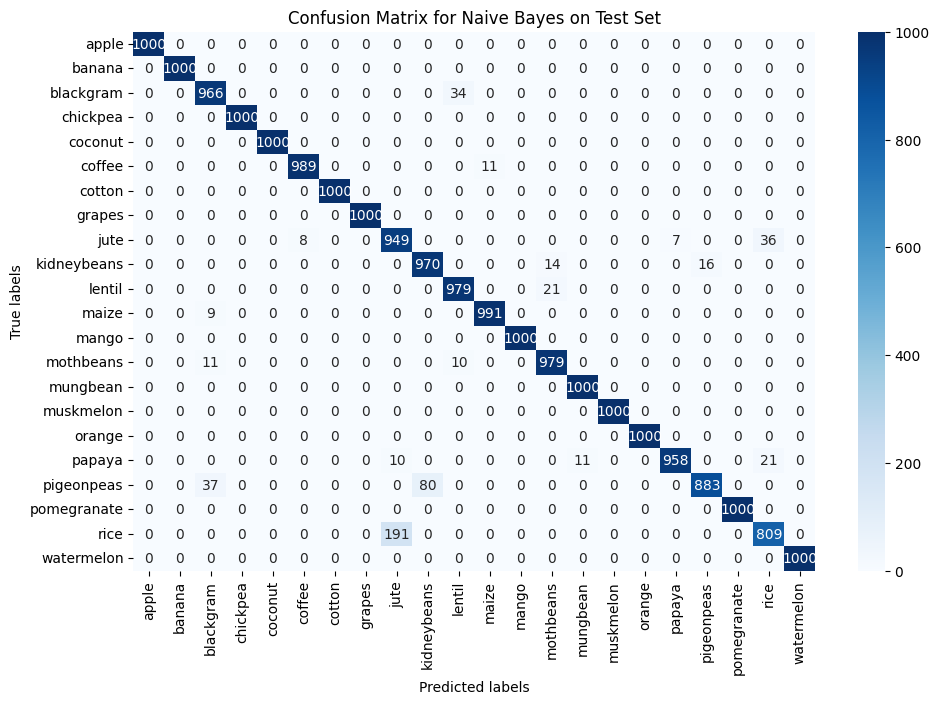

In [11]:

# Set up the RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Set var_smoothing parameter for regularization
var_smoothing_value = 1e-1
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 10-fold cross-validation on undersampled data
cv_scores = cross_val_score(clf_nb, X_train_under, y_train_under, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the clf_nb with the undersampled training data
clf_nb.fit(X_train_under, y_train_under)

# Calibrate the classifier
calibrated_nb = CalibratedClassifierCV(clf_nb, method='sigmoid', cv='prefit')
calibrated_nb.fit(X_val, y_val)

# Predict for the training set using the calibrated model
y_pred_nb_train = calibrated_nb.predict(X_train)
accuracy_score_nb_train = accuracy_score(y_train, y_pred_nb_train)

# Predict for the validation set using the calibrated model
y_pred_nb_val = calibrated_nb.predict(X_val)
accuracy_score_nb_val = accuracy_score(y_val, y_pred_nb_val)

# Predict for the test set using the calibrated model
y_pred_nb = calibrated_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_knn)
print("Naive Bayes Validation accuracy:", accuracy_score_nb_val)
print("Naive Bayes Test accuracy:", accuracy_nb)
print("Naive Bayes Test Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Compute metrics for model_metrics dictionary
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average='weighted')
model_metrics_nb = {
    "Accuracy": f"{accuracy_nb * 100:.2f}%",
    "Precision": f"{precision_nb * 100:.2f}%",
    "Recall": f"{recall_nb * 100:.2f}%",
    "F1 Score": f"{f1_nb * 100:.2f}%"
}
# Compute the confusion matrix for the test set
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

# Extract unique class labels
class_labels = np.unique(y)

# Plot using Seaborn for the test set
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_nb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes on Test Set')
plt.show()



Cross-validated accuracy scores for each fold: [0.91376623 0.90766234 0.91454545 0.92       0.91090909 0.91233766
 0.91077922 0.91441558 0.91415584 0.90896104]
Mean CV Accuracy: 0.9127532467532469
Standard Deviation of CV Accuracy: 0.0033053415118105747
Logistic Regression Validation accuracy: 0.9050909090909091
Logistic Regression Test accuracy: 0.9069090909090909
Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       0.99      1.00      0.99      1000
   blackgram       0.79      0.98      0.87      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.98      0.98      0.98      1000
      coffee       0.96      1.00      0.98      1000
      cotton       0.93      0.91      0.92      1000
      grapes       1.00      0.91      0.95      1000
        jute       0.80      0.85      0.82      1000
 kidneybeans       0.95      0.92      0.93

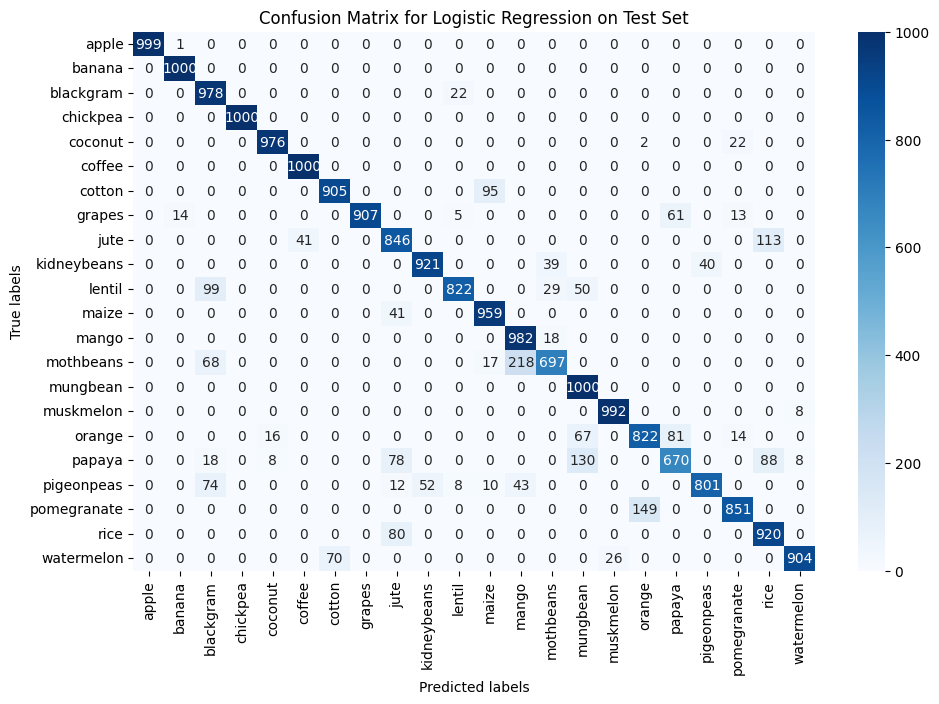

In [12]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with stronger regularization (smaller C value)
clf_lr = LogisticRegression(C=0.001, max_iter=5000, random_state=0)
clf_lr.fit(X_train_scaled, y_train)

# Calibrating the classifier using the previously fitted instance
calibrated_clf = CalibratedClassifierCV(clf_lr, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_val_scaled, y_val)

# Perform 10-fold cross-validation on the training data with original classifier
cv_scores = cross_val_score(clf_lr, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Predict on the validation set using calibrated classifier
y_pred_lr_val = calibrated_clf.predict(X_val_scaled)
accuracy_score_lr_val = accuracy_score(y_val, y_pred_lr_val)
print("Logistic Regression Validation accuracy:", accuracy_score_lr_val)

# Predict on the test set using calibrated classifier
y_pred_lr = calibrated_clf.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Print the Logistic Regression Classification Report for the test set
print("Logistic Regression Test accuracy:", accuracy_lr)
print("Logistic Regression Test Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Compute metrics for model_metrics dictionary
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')
model_metrics_lr = {
    "Accuracy": f"{accuracy_lr * 100:.2f}%",
    "Precision": f"{precision_lr * 100:.2f}%",
    "Recall": f"{recall_lr * 100:.2f}%",
    "F1 Score": f"{f1_lr * 100:.2f}%"
}

# Compute the confusion matrix for the test set
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# Extract unique class labels
class_labels = np.unique(y)

# Plot using Seaborn for the test set
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_lr, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.show()


Cross-validated accuracy scores for each fold: [0.96922078 0.97597403 0.97       0.96909091 0.97207792 0.96636364
 0.96662338 0.96701299 0.96766234 0.96558442]
Mean CV Accuracy: 0.968961038961039
Standard Deviation of CV Accuracy: 0.002985883467975814
Calibrated XGBoost Validation accuracy: 0.9753636363636363
XGBoost Test accuracy: 0.9740454545454545
XGBoost Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.95      0.98      0.96      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      0.98      0.99      1000
      coffee       1.00      1.00      1.00      1000
      cotton       0.99      1.00      0.99      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.84      1.00      0.91      1000
 kidneybeans       1.00      1.00      1.00      1000
      lentil    

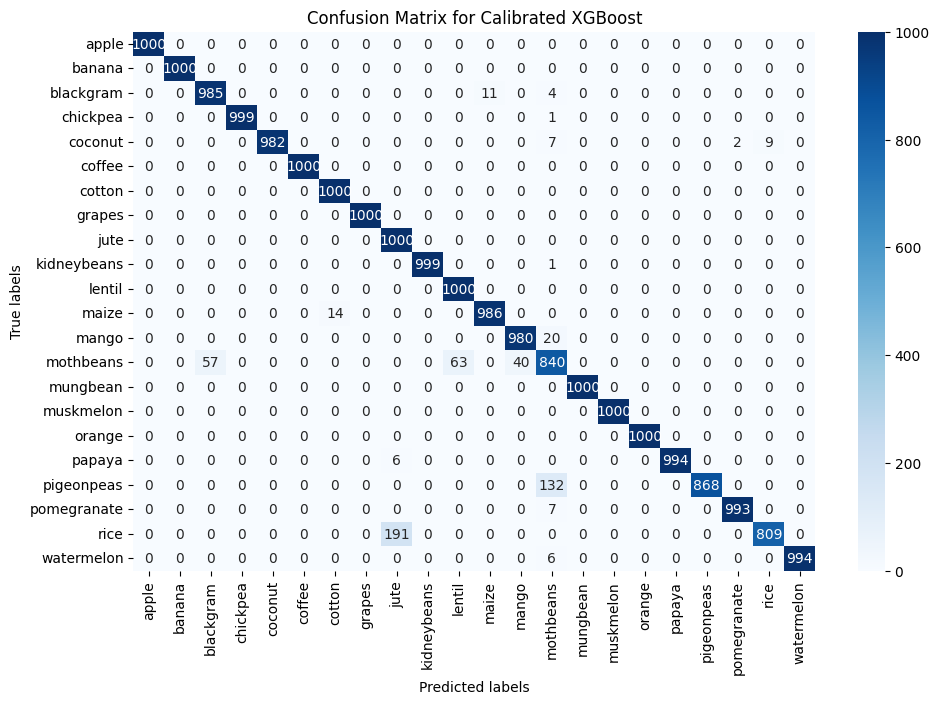

In [13]:
# Convert string labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Define the XGBoost classifier
clf_xgb = xgb.XGBClassifier(
    n_estimators=5,
    max_depth=3,
    min_child_weight=5,
    gamma=0.01,
    learning_rate=0.03,
    objective='multi:softmax',
    random_state=0
)

# Fit the model to the training data
clf_xgb.fit(X_train, y_train_encoded)

# Perform 10-fold cross-validation on the original XGBClassifier
cv_scores = cross_val_score(clf_xgb, X_train, y_train_encoded, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Calibrate the classifier AFTER the cross-validation
calibrated_xgb = CalibratedClassifierCV(clf_xgb, method='sigmoid', cv='prefit')
calibrated_xgb.fit(X_val, y_val_encoded)

# Predict on the validation set using the calibrated classifier
y_pred_xgb_val = le.inverse_transform(calibrated_xgb.predict(X_val))

# Compute the accuracy for the validation set
accuracy_score_xgb_val = accuracy_score(y_val, y_pred_xgb_val)
print("Calibrated XGBoost Validation accuracy:", accuracy_score_xgb_val)

# Decode the predicted labels to original string format for the test set
y_pred_xgb = le.inverse_transform(calibrated_xgb.predict(X_test))

# Use the decoded predicted labels for calculating accuracy and plotting confusion matrix
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Test accuracy:", accuracy_xgb)
print("XGBoost Test Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Extract unique class labels from y_train
class_labels = np.unique(y_train)

# Compute metrics for model_metrics dictionary
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='weighted')
model_metrics_xgb = {
    "Accuracy": f"{accuracy_xgb * 100:.2f}%",
    "Precision": f"{precision_xgb * 100:.2f}%",
    "Recall": f"{recall_xgb * 100:.2f}%",
    "F1 Score": f"{f1_xgb * 100:.2f}%"
}

# Compute the confusion matrix
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_xgb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Calibrated XGBoost')
plt.show()


In [14]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_rf)
print("KNN:", accuracy_knn)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Logistic Regression Accuracy", accuracy_lr)
print("XGBoost Accuracy:", accuracy_xgb)


Random Forest Accuracy: 0.9600454545454545
KNN: 0.9570454545454545
Naive Bayes Accuracy: 0.9570454545454545
Logistic Regression Accuracy 0.9069090909090909
XGBoost Accuracy: 0.9740454545454545


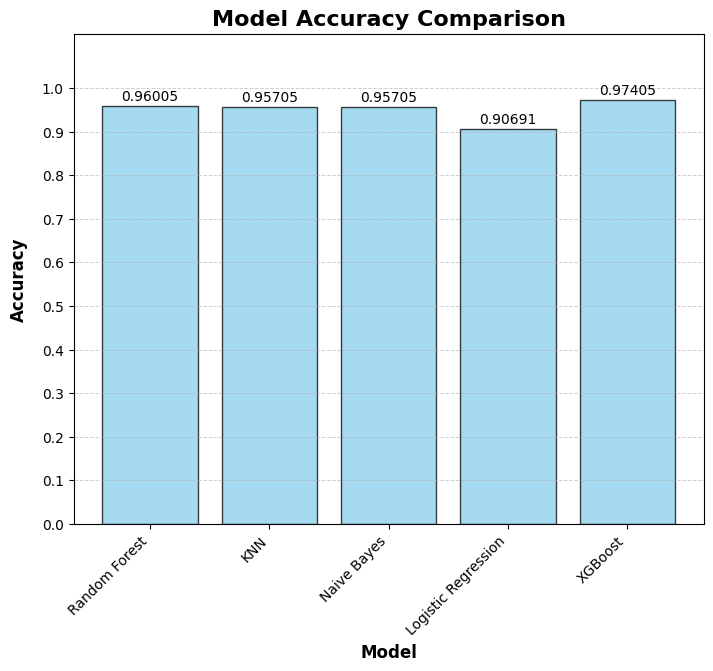

In [15]:
model_names = ['Random Forest', 'KNN', 'Naive Bayes', 'Logistic Regression', 'XGBoost']
accuracies = [accuracy_rf, accuracy_knn, accuracy_nb, accuracy_lr, accuracy_xgb] 

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Using consistent colors with a slight alpha transparency and edge color
bars = ax.bar(model_names, accuracies, color='skyblue', alpha=0.75, edgecolor='black')

# Adding data labels with 4 decimal places
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, "{:.5f}".format(yval), ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10)  # labelpad adds some padding to the ylabel
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.125)  # Added a bit more space at the top for the data labels
ax.set_yticks([i/10 for i in range(11)])
ax.set_yticklabels([i/10 for i in range(11)], fontsize=10)
ax.set_xticks(range(len(model_names)))

# Adjusting font size of the classifier names
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Reduced font size to 10

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)  # Adding horizontal grid lines

# Adjust the position of the axes to create margins inside the chart
ax.set_position([0.5, 0.5, 0.7, 0.7])  # left, bottom, width, height


plt.show()

Define original feature names and input data

In [20]:
original_feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
data = np.array([[25, 51, 18, 27.77799528, 54.82130787, 9.45949344, 50.28438729]])
data_df = pd.DataFrame(data, columns=original_feature_names)


**Define Classifier**

In [21]:
classifiers = {
    "Random Forest": clf_rf,
    "KNN": clf_knn,
    "Naive Bayes": clf_nb,
    "Logistic Regression": clf_lr,
    "XGBoost": clf_xgb,
}

**Ensemble Prediction Function**
<br>We'll encapsulate the ensemble prediction logic into a function.

In [25]:
def ensemble_predict(classifiers, data_df, le=None):
    # Convert data_df to 2D if it's 1D
    if len(data_df.shape) == 1:
        data_df = data_df.values.reshape(1, -1)
    else:
        data_df = data_df.values
        
    votes = []
    for clf_name, clf in classifiers.items():
        proba = clf.predict_proba(data_df)
        predicted_index = np.argmax(proba)
        
        if clf_name == "XGBoost" and le:
            predicted_label = le.inverse_transform([predicted_index])[0]
        else:
            predicted_label = clf.classes_[predicted_index]

        votes.append(predicted_label)
    
    vote_counts = Counter(votes)
    most_common_votes = vote_counts.most_common()
    if len(most_common_votes) > 1 and most_common_votes[0][1] == most_common_votes[1][1]:
        tied_classes = [vote[0] for vote in most_common_votes if vote[1] == most_common_votes[0][1]]
        return tied_classes[0]
    else:
        return most_common_votes[0][0]


**Ensemble Metrics Calculation**
<br>
This is where we'll genuinely calculate the ensemble metrics by using the hard voting mechanism on a separate test dataset.

In [26]:
def calculate_ensemble_metrics(classifiers, X_test, y_test, le=None):
    y_preds = [ensemble_predict(classifiers, pd.Series(row), le) for row in X_test.values]
    metrics = {
        'Accuracy': accuracy_score(y_test, y_preds),
        'Precision': precision_score(y_test, y_preds, average='weighted'),
        'Recall': recall_score(y_test, y_preds, average='weighted'),
        'F1 Score': f1_score(y_test, y_preds, average='weighted')
    }
    return metrics


**Visualization and Outputs**
<br>
Here we visualize the ensemble predictions and show the results in a tabular format.

Model-wise Predictions:
| Model Name            | Prediction   |
|-----------------------|--------------|
| Random Forest         | mothbeans    |
| KNN                   | apple        |
| Naive Bayes           | mothbeans    |
| Logistic Regression   | papaya       |
| XGBoost               | mothbeans    |


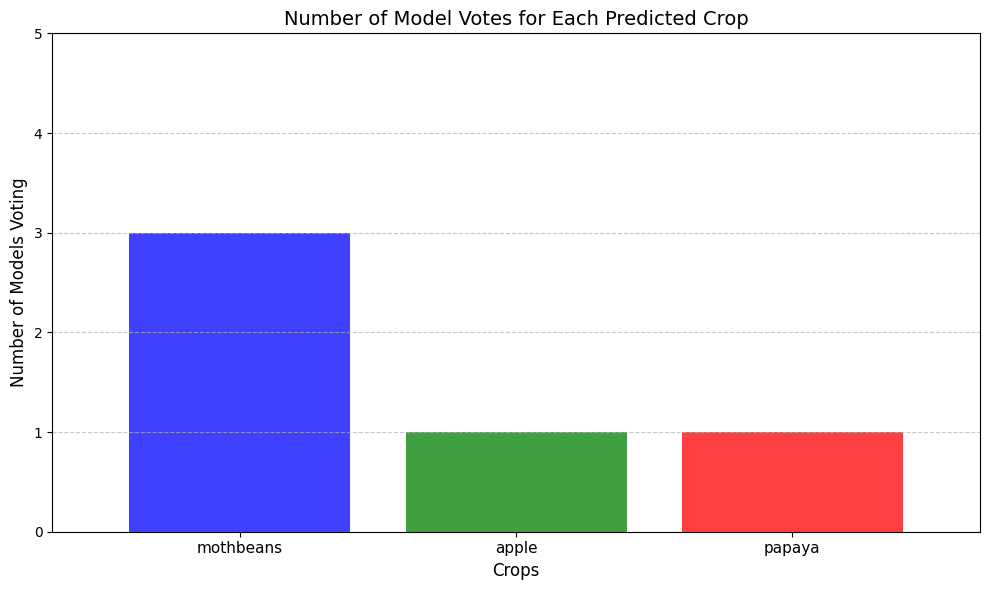


--------------------------------------------------
              ENSEMBLE PREDICTION RESULT      
--------------------------------------------------
| Crop Predicted   | mothbeans                   |
|------------------|-----------------------------|
| Accuracy         | 0.9489545454545455          |
| Precision        | 0.9710126116782333          |
| Recall           | 0.9489545454545455          |
| F1 Score         | 0.9427081557215428          |
--------------------------------------------------

Note:
The ensemble prediction is derived from a majority consensus across various models.


In [27]:
# Using the ensemble prediction function
ensemble_prediction = ensemble_predict(classifiers, data_df, le)

# Getting metrics using the function (assuming you have X_test and y_test)
ensemble_metrics = calculate_ensemble_metrics(classifiers, X_test, y_test, le)

# Tabular Representation of Model-wise Predictions
print("Model-wise Predictions:")
print("| Model Name            | Prediction   |")
print("|-----------------------|--------------|")
for clf_name, clf in classifiers.items():
    proba = clf.predict_proba(data_df.values)
    predicted_index = np.argmax(proba)
    
    if clf_name == "XGBoost" and le:
        predicted_label = le.inverse_transform([predicted_index])[0]
    else:
        predicted_label = clf.classes_[predicted_index]
    print(f"| {clf_name:<21} | {predicted_label:<12} |")

# Visualization: Histogram of Predictions
vote_counts = Counter(votes)
plt.figure(figsize=(10,6))
colors = ['blue', 'green', 'red', 'cyan', 'purple']
plt.bar(vote_counts.keys(), vote_counts.values(), color=colors, alpha=0.75)
plt.yticks(np.arange(0, 6, 1))
plt.ylim(0, 5)
plt.ylabel('Number of Models Voting', fontsize=12)
plt.xlabel('Crops', fontsize=12)
plt.title('Number of Model Votes for Each Predicted Crop', fontsize=14)
plt.xticks(rotation=0, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(0.1)
plt.tight_layout()
plt.show()

# Tabular Representation of Ensemble Prediction Results
print("\n--------------------------------------------------")
print("              ENSEMBLE PREDICTION RESULT      ")
print("--------------------------------------------------")
print(f"| Crop Predicted   | {ensemble_prediction:<27} |")
print("|------------------|-----------------------------|")
print(f"| Accuracy         | {ensemble_metrics['Accuracy']:<27} |")
print(f"| Precision        | {ensemble_metrics['Precision']:<27} |")
print(f"| Recall           | {ensemble_metrics['Recall']:<27} |")
print(f"| F1 Score         | {ensemble_metrics['F1 Score']:<27} |")
print("--------------------------------------------------")
print("\nNote:")
print("The ensemble prediction is derived from a majority consensus across various models.")


In [ ]:
### MAKING PREDICTIONS BELOW FROM PREVIOUS CODE ###

Model-wise Predictions:
| Model Name            | Prediction   |
|-----------------------|--------------|
| Random Forest         | mothbeans    |
| KNN                   | apple        |
| Naive Bayes           | mothbeans    |
| Logistic Regression   | papaya       |
| XGBoost               | mothbeans    |


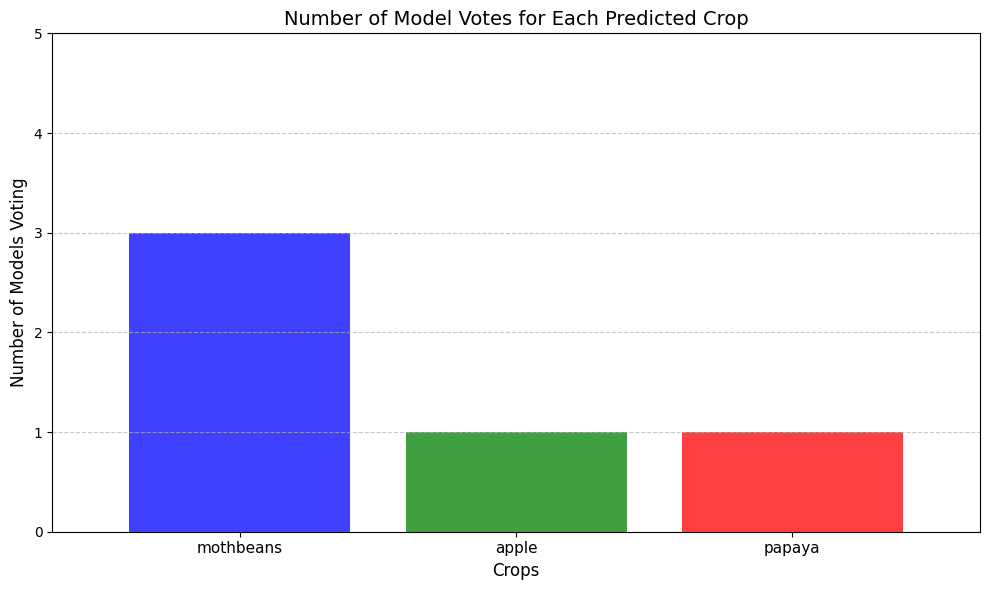


--------------------------------------------------
              ENSEMBLE PREDICTION RESULT      
--------------------------------------------------
| Crop Predicted   | mothbeans                   |
|------------------|-----------------------------|
| Accuracy         | 0.9683181818181819          |
| Precision        | 0.9748868699371772          |
| Recall           | 0.9683181818181819          |
| F1 Score         | 0.9662126315409544          |
--------------------------------------------------

Note:
The ensemble prediction is derived from a majority consensus across various models.


In [28]:
# # Define the original feature names and input data
# original_feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
# data = np.array([[25, 51, 18, 27.77799528, 54.82130787, 9.45949344, 50.28438729]])
# data_df = pd.DataFrame(data, columns=original_feature_names)


# classifiers = {
#     "Random Forest": clf_rf,
#     "KNN": clf_knn,
#     "Naive Bayes": clf_nb,
#     "Logistic Regression": clf_lr,
#     "XGBoost": clf_xgb,
# }

# votes = []

# # Iterate over classifiers to get their predictions
# for clf_name, clf in classifiers.items():
#     proba = clf.predict_proba(data_df.values)
#     predicted_index = np.argmax(proba)
    
#     if clf_name == "XGBoost":
#         predicted_label = le.inverse_transform([predicted_index])[0]
#     else:
#         predicted_label = clf.classes_[predicted_index]
    
#     votes.append(predicted_label)

# # Ensemble voting
# vote_counts = Counter(votes)
# most_common_votes = vote_counts.most_common()

# if len(most_common_votes) > 1 and most_common_votes[0][1] == most_common_votes[1][1]:
#     tied_classes = [vote[0] for vote in most_common_votes if vote[1] == most_common_votes[0][1]]
#     ensemble_prediction = tied_classes[0]
# else:
#     ensemble_prediction = most_common_votes[0][0]

# # Here's the model metrics dictionary
# model_metrics = {
#     "Random Forest": {"Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf, "F1 Score": f1_rf},
#     "KNN": {"Accuracy": accuracy_knn, "Precision": precision_knn, "Recall": recall_knn, "F1 Score": f1_knn},
#     "Naive Bayes": {"Accuracy": accuracy_nb, "Precision": precision_nb, "Recall": recall_nb, "F1 Score": f1_nb},
#     "Logistic Regression": {"Accuracy": accuracy_lr, "Precision": precision_lr, "Recall": precision_lr, "F1 Score": f1_lr},
#     "XGBoost": {"Accuracy": accuracy_xgb, "Precision": precision_xgb, "Recall": recall_xgb, "F1 Score": recall_xgb}
# }

# # Getting metrics of the ensemble prediction from the model that matches the ensemble result
# matching_model = [clf_name for clf_name, predicted_label in zip(classifiers, votes) if predicted_label == ensemble_prediction][0]
# ensemble_metrics = model_metrics.get(matching_model, {"Accuracy": "-", "Precision": "-", "Recall": "-", "F1 Score": "-"})

# # Tabular Representation of Model-wise Predictions
# print("Model-wise Predictions:")
# print("| Model Name            | Prediction   |")
# print("|-----------------------|--------------|")
# for clf_name in classifiers:
#     predicted_label = votes[list(classifiers.keys()).index(clf_name)]
#     print(f"| {clf_name:<21} | {predicted_label:<12} |")

# # Visualization: Histogram of Predictions
# plt.figure(figsize=(10,6))
# colors = ['blue', 'green', 'red', 'cyan', 'purple']
# plt.bar(vote_counts.keys(), vote_counts.values(), color=colors, alpha=0.75)
# plt.yticks(np.arange(0, 6, 1))
# plt.ylim(0, 5)
# plt.ylabel('Number of Models Voting', fontsize=12)
# plt.xlabel('Crops', fontsize=12)
# plt.title('Number of Model Votes for Each Predicted Crop', fontsize=14)
# plt.xticks(rotation=0, fontsize=11)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.margins(0.1)
# plt.tight_layout()
# plt.show()

# # Tabular Representation of Ensemble Prediction Results
# print("\n--------------------------------------------------")
# print("              ENSEMBLE PREDICTION RESULT      ")
# print("--------------------------------------------------")
# print(f"| Crop Predicted   | {ensemble_prediction:<27} |")
# print("|------------------|-----------------------------|")
# print(f"| Accuracy         | {ensemble_metrics['Accuracy']:<27} |")
# print(f"| Precision        | {ensemble_metrics['Precision']:<27} |")
# print(f"| Recall           | {ensemble_metrics['Recall']:<27} |")
# print(f"| F1 Score         | {ensemble_metrics['F1 Score']:<27} |")
# print("--------------------------------------------------")
# print("\nNote:")
# print("The ensemble prediction is derived from a majority consensus across various models.")
